## Building a GPT

Companion notebook to the [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT.

### Full finished code, for reference

You may want to refer directly to the git repo instead though.

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200

dropout = 0.0
# ------------

torch.manual_seed(1337)

In [2]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-06-16 14:13:31--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.008s  

2025-06-16 14:13:32 (140 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [3]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string


In [4]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [5]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, embed_size):
        super().__init__()
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) #block_size is basically the context window of tokens we look at so tril is (num_token, num_token)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape # batch x num_tokens x n_embd
        k = self.key(x)   # (batch, num_tokens, head_size)
        q = self.query(x) # (batch, num_tokens, head_size)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (batch, num tokens, head_size) @ (batch, head_size, num_token) -> (B, num_token, num_token) # the b, i, jth element is dot product of the ith tokens query and jth tokens key vectors of the bth batch
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, num_token, num_token); set all upper traingular elements above the diagonal to -inf
        wei = F.softmax(wei, dim=-1) # (batch, num_token, num_token)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (batch, num_tokens, head_size)
        out = wei @ v # (batch, num_token, num_token) @ (batch, num_token, head_size) -> (batch, num_token, head_size)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        n_embd = num_heads * head_size
        self.heads = nn.ModuleList([Head(head_size, n_embd) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) #h(x) returns a tensor of size (batch, num_tokens, head_size) so torch.cat is concatenating the outputs of each head along the head_size dimension
        out = self.dropout(self.proj(out)) #self.proj(out) converts tensor of size (batch, num_tokens, n_embd) to (batch, num_tokens, n_embd)
        return out

class AveragingMultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        n_embd =  head_size
        self.heads = nn.ModuleList([Head(head_size, n_embd) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        avg = torch.stack([h(x) for h in self.heads], dim=-1).mean(dim=-1)
        out = self.dropout(self.proj(avg)) #self.proj(out) converts tensor of size (batch, num_tokens, n_embd) to (batch, num_tokens, n_embd)
        return out


class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head #currently each the context vector produced by each head is getting concatenated along the context vector dimension so defining head_size likes this keeps the size of the context vector to n_embd dim
        self.sa = MultiHeadAttention(n_head, head_size) #self.sa will return a tensor of size (batch, num_tokens, n_embd)
        self.ffwd = FeedFoward(n_embd) #a FF network that keeps the dimensions the same
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x): #x is of dim (batch, num_tokens, n_embd)
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class Averaging_Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.sa = AveragingMultiHeadAttention(n_head, n_embd) #self.sa will return a tensor of size (batch, num_tokens, n_embd)
        self.ffwd = FeedFoward(n_embd) #a FF network that keeps the dimensions the same
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x): #x is of dim (batch, num_tokens, n_embd)
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self, num_layers=4, embed_size = 64, num_attn_heads = 4):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size) #vocab_size x 64
        self.position_embedding_table = nn.Embedding(block_size, embed_size) #block_size x 64
        self.blocks = nn.Sequential(*[Block(embed_size, n_head=num_attn_heads) for _ in range(num_layers)]) #runs thru many blocks sequentially (where each block applies multihead attention and a feedforward network with layer norm and skip connections layered in)
        self.ln_f = nn.LayerNorm(embed_size) # final layer norm
        self.lm_head = nn.Linear(embed_size, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B, num_tokens, n_embd)
        x = self.blocks(x) # (B, num_tokens, n_embd)
        x = self.ln_f(x) # (B, num_tokens, n_embd)
        logits = self.lm_head(x) # (B,num_tokens, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

class BigramLanguageModel2(nn.Module):

    def __init__(self, num_layers=4, embed_size = 64, num_attn_heads = 4):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size) #vocab_size x 64
        self.position_embedding_table = nn.Embedding(block_size, embed_size) #block_size x 64
        self.blocks = nn.Sequential(*[Averaging_Block(embed_size, n_head=num_attn_heads) for _ in range(num_layers)]) #runs thru many blocks sequentially (where each block applies multihead attention and a feedforward network with layer norm and skip connections layered in)
        self.ln_f = nn.LayerNorm(embed_size) # final layer norm
        self.lm_head = nn.Linear(embed_size, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B, num_tokens, n_embd)
        x = self.blocks(x) # (B, num_tokens, n_embd)
        x = self.ln_f(x) # (B, num_tokens, n_embd)
        logits = self.lm_head(x) # (B,num_tokens, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel() #instantiate model
model2 = BigramLanguageModel2() #averages the context vectors produced by each attention head instead of concatenating

things I could build on:
- modify multi head attention to average along the context vector dimension instead of concatenating
- play around with hyperparameters (learning rate, num layers, embedding size, num training iterations)
- train on different dataset
- instead of character based vocabulary, use different tokenizing methodology
- using transformers/self-attention for non text tasks

In [29]:
m = model.to(device) #move to GPU if available

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
base_model_loss_dict = {}
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) #create optimizier on model parameters

for iter in range(max_iters): #run max_iters times

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model)
        base_model_loss_dict[iter] = [losses['train'], losses['val']]
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train') #returns input and target tensors of size (batch, block_size)

    # evaluate the loss
    logits, loss = model(xb, yb) #run fwd pass and compute loss
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step() #backprop loss

# generate from the model

#context = torch.zeros((1, 1), dtype=torch.long, device=device)
#print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
step 0: train loss 4.2813, val loss 4.2906
step 100: train loss 2.6551, val loss 2.6707
step 200: train loss 2.4934, val loss 2.5133
step 300: train loss 2.4086, val loss 2.4058
step 400: train loss 2.3475, val loss 2.3500
step 500: train loss 2.2870, val loss 2.2876
step 600: train loss 2.2287, val loss 2.2570
step 700: train loss 2.1909, val loss 2.2159
step 800: train loss 2.1665, val loss 2.1969
step 900: train loss 2.1264, val loss 2.1663
step 1000: train loss 2.0980, val loss 2.1238
step 1100: train loss 2.0608, val loss 2.1018
step 1200: train loss 2.0269, val loss 2.0847
step 1300: train loss 2.0044, val loss 2.0693
step 1400: train loss 1.9867, val loss 2.0618
step 1500: train loss 1.9606, val loss 2.0419
step 1600: train loss 1.9472, val loss 2.0237
step 1700: train loss 1.9253, val loss 2.0188
step 1800: train loss 1.9060, val loss 1.9958
step 1900: train loss 1.8807, val loss 1.9933
step 2000: train loss 1.8818, val loss 1.9869
step 2100: train loss 1.

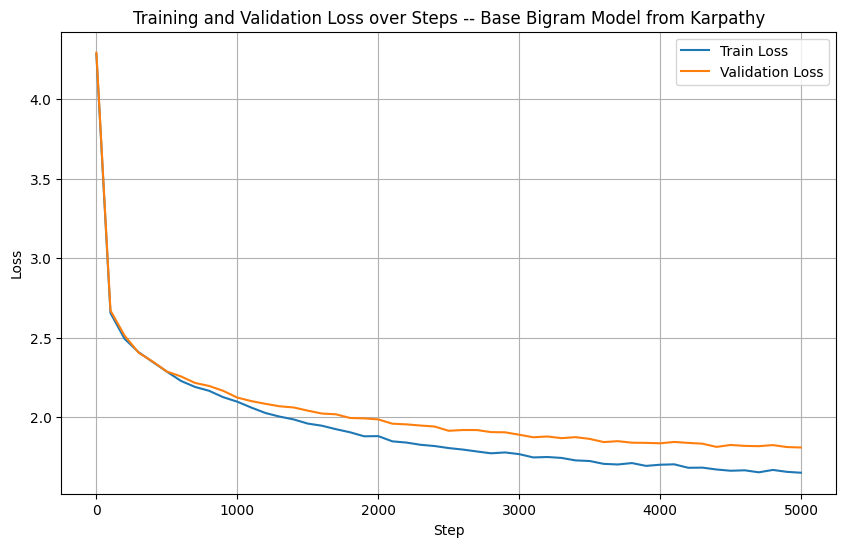

In [30]:
# prompt: use matplotlib to plot the loss values in base_model_loss_dict. The keys are the step index. The values are lists of len-2 where the first element is the train loss and the second element is the val loss. Plot both losses

import matplotlib.pyplot as plt

# Extract step indices and loss values
steps = list(base_model_loss_dict.keys())
train_losses = [loss_values[0].cpu().numpy() for loss_values in base_model_loss_dict.values()]
val_losses = [loss_values[1].cpu().numpy() for loss_values in base_model_loss_dict.values()]

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label='Train Loss')
plt.plot(steps, val_losses, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Steps -- Base Bigram Model from Karpathy')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
m2 = model2.to(device) #move to GPU if available

# print the number of parameters in the model
print(sum(p.numel() for p in m2.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
model2_loss_dict = {}
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=learning_rate) #create optimizier on model parameters

for iter in range(max_iters): #run max_iters times

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model2)
        model2_loss_dict[iter] = [losses['train'], losses['val']]
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train') #returns input and target tensors of size (batch, block_size)

    # evaluate the loss
    logits, loss = model2(xb, yb) #run fwd pass and compute loss
    optimizer2.zero_grad(set_to_none=True)
    loss.backward()
    optimizer2.step() #backprop loss

# generate from the model

#context = torch.zeros((1, 1), dtype=torch.long, device=device)
#print(decode(m2.generate(context, max_new_tokens=2000)[0].tolist()))

0.357185 M parameters
step 0: train loss 4.3468, val loss 4.3440
step 100: train loss 2.6580, val loss 2.6568
step 200: train loss 2.4674, val loss 2.4673
step 300: train loss 2.3561, val loss 2.3615
step 400: train loss 2.2875, val loss 2.2868
step 500: train loss 2.2145, val loss 2.2144
step 600: train loss 2.1573, val loss 2.1747
step 700: train loss 2.1054, val loss 2.1471
step 800: train loss 2.0725, val loss 2.1162
step 900: train loss 2.0312, val loss 2.0907
step 1000: train loss 1.9979, val loss 2.0550
step 1100: train loss 1.9829, val loss 2.0361
step 1200: train loss 1.9558, val loss 2.0319
step 1300: train loss 1.9198, val loss 1.9969
step 1400: train loss 1.9095, val loss 2.0021
step 1500: train loss 1.8845, val loss 1.9900
step 1600: train loss 1.8647, val loss 1.9803
step 1700: train loss 1.8705, val loss 1.9789
step 1800: train loss 1.8544, val loss 1.9673
step 1900: train loss 1.8252, val loss 1.9596
step 2000: train loss 1.8125, val loss 1.9210
step 2100: train loss 1.

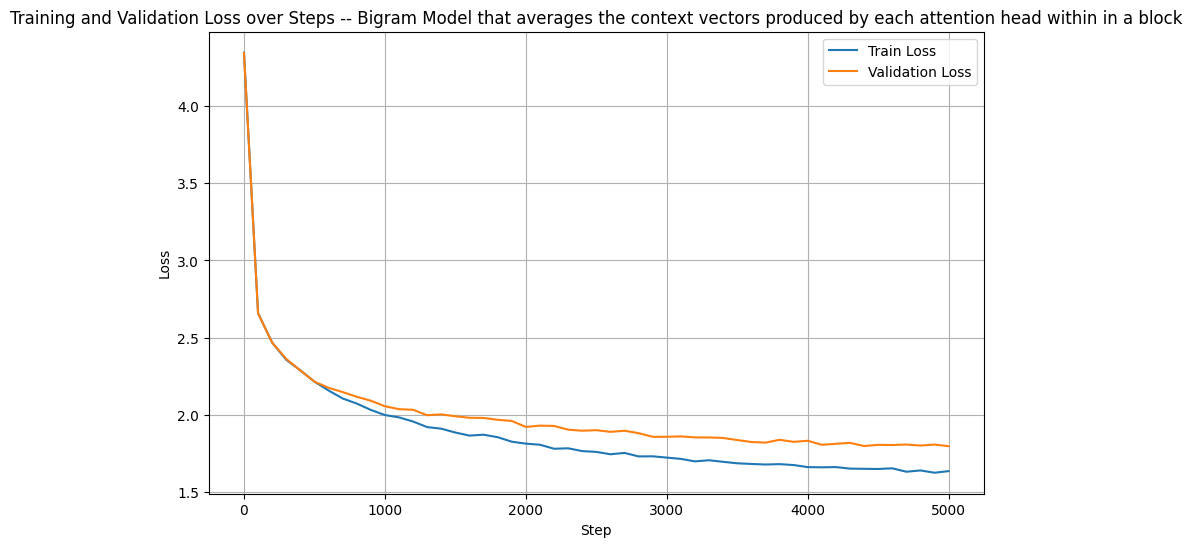

In [19]:
steps = list(model2_loss_dict.keys())
train_losses = [loss_values[0].cpu().numpy() for loss_values in model2_loss_dict.values()]
val_losses = [loss_values[1].cpu().numpy() for loss_values in model2_loss_dict.values()]

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label='Train Loss')
plt.plot(steps, val_losses, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Steps -- Bigram Model that averages the context vectors produced by each attention head within in a block')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
#base models above were trained with num_layers=4, embed_size = 64, num_attn_heads = 4


model_loss_dict = {}

model2 = BigramLanguageModel2(6, 64, 8)
m2 = model2.to(device) #move to GPU if available
num_prams = sum(p.numel() for p in m2.parameters())


# create a PyTorch optimizer
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=learning_rate) #create optimizier on model parameters

for iter in range(max_iters): #run max_iters times

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model2)
        model_loss_dict[iter] = [losses['train'], losses['val']]
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train') #returns input and target tensors of size (batch, block_size)

    # evaluate the loss
    logits, loss = model2(xb, yb) #run fwd pass and compute loss
    optimizer2.zero_grad(set_to_none=True)
    loss.backward()
    optimizer2.step() #backprop loss


step 0: train loss 4.3623, val loss 4.3748
step 100: train loss 2.6366, val loss 2.6379
step 200: train loss 2.4467, val loss 2.4437
step 300: train loss 2.3389, val loss 2.3517
step 400: train loss 2.2643, val loss 2.2716
step 500: train loss 2.1936, val loss 2.2099
step 600: train loss 2.1389, val loss 2.1750
step 700: train loss 2.0901, val loss 2.1295
step 800: train loss 2.0582, val loss 2.1200
step 900: train loss 2.0142, val loss 2.0849
step 1000: train loss 1.9862, val loss 2.0605
step 1100: train loss 1.9520, val loss 2.0294
step 1200: train loss 1.9196, val loss 2.0124
step 1300: train loss 1.8899, val loss 1.9787
step 1400: train loss 1.8830, val loss 1.9762
step 1500: train loss 1.8495, val loss 1.9570
step 1600: train loss 1.8340, val loss 1.9627
step 1700: train loss 1.8181, val loss 1.9443
step 1800: train loss 1.8094, val loss 1.9356
step 1900: train loss 1.7905, val loss 1.9175
step 2000: train loss 1.7705, val loss 1.9111
step 2100: train loss 1.7720, val loss 1.9051


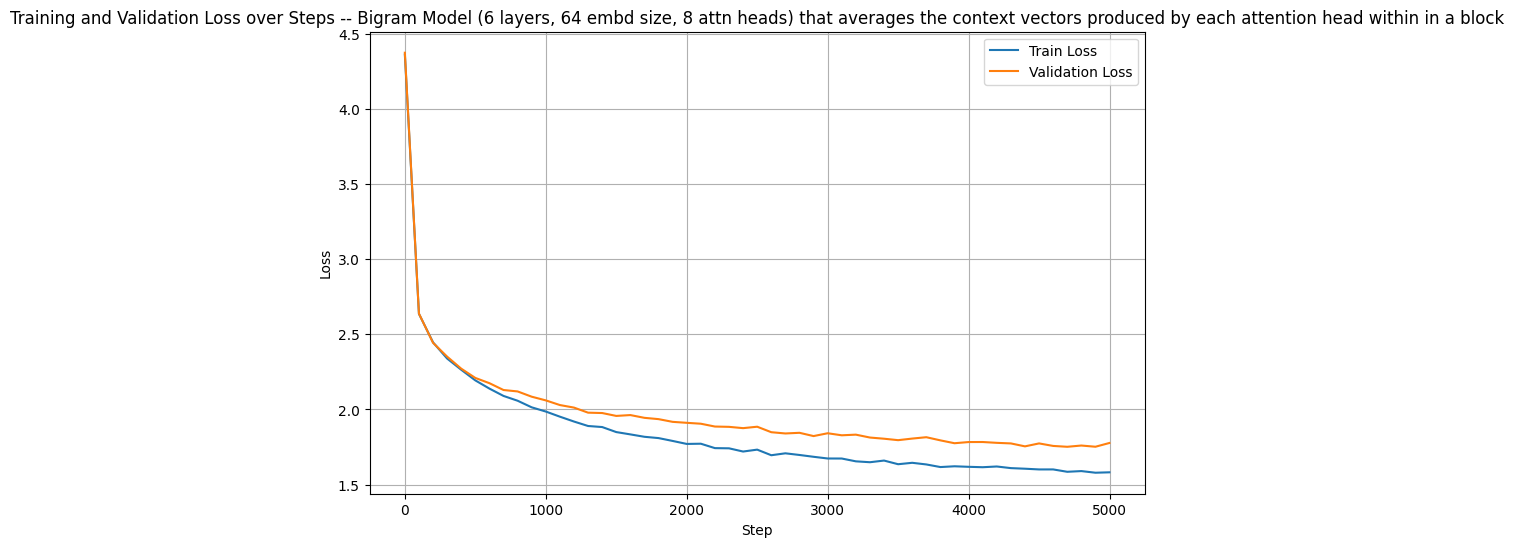

In [9]:
steps = list(model_loss_dict.keys())
train_losses = [loss_values[0].cpu().numpy() for loss_values in model_loss_dict.values()]
val_losses = [loss_values[1].cpu().numpy() for loss_values in model_loss_dict.values()]

import matplotlib.pyplot as plt

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label='Train Loss')
plt.plot(steps, val_losses, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Steps -- Bigram Model (6 layers, 64 embd size, 8 attn heads) that averages the context vectors produced by each attention head within in a block')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
print(sum(p.numel() for p in m2.parameters())/1e6, 'M parameters')

0.825409 M parameters


In [11]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m2.generate(context, max_new_tokens=5000)[0].tolist()))


And they bride.

KING RICHARD II:
Petecube to take Ond my dalied
My armit her wish hert?
Feether at, away, my facks, to zonour
Yourselt friance of my fall
Whices is east hein lattent, move speak;
Where are arrabout like disecute-husback him speak; and thew ye will full roopes, and whom
the odly that
mont-not what prings the most rive
And him crop-opples for under danter,
Whe so; sirres muft not in excatch:
For in thy oment from and to be saw adstle,
And he match best a are no vext stoney the fack'd part,
And summers and gamest so a chmost.

DUKE VINCENTIO:
Was steat to disson's were or the much friencess
Decas lord
Is as deture in stroved pardon's look:
He passe to their pover so;
On the has branes hate not come,
Over procks, no duke on, so make her habbands again
Abut we me of thy lumb neck do scollow.

Provost:
My honours?
Their hath brother's with tyrant the of time
To draight eyes mon appring'd what thou rage us.

ESBRUM:
Clarence he met part.

BENVOUCLIO:
Wout is not fly thee, ou

Even though, there is ~500k more parameters in the model with 6 layers and 8 attn heads as compared to the model with 4 layers and 4 attention heads, the performance on the larger model is only marginally better. The validation loss on the larger model after 5000 training steps is 1.7768. In the smaller model, it is 1.7961.